# Causal Data Science Week 3 Tutorial

In this tutorial, we will cover how to identify estimands in your causal graph. We will first apply the backdoor, instrumental variable, and frontdoor criterions manually to identify the estimands. We will then look at how DoWhy can do this for you automatically.

### Backdoor Criterion

The backdoor criterion allows us to identify the variables on which we need to condition to calculate our causal estimates. We identify these variables by looking at 'backwards' paths from the treatment variable.

The criterion is given as follows:\
Given an ordered pair of variables ($X$, $Y$) in a directed acyclic graph G, a set of variables **Z** satisfies the backdoor criterion relative to ($X$, $Y$) if no node in **Z** is a descendant of $X$, and **Z** blocks every path between $X$ and $Y$ that contains an arrow into $X$.

This definition, and the example below, are taken from: https://medium.data4sci.com/causal-inference-part-xi-backdoor-criterion-e29627a1da0e

Let's create a network and manually identify adjustment sets based on the backdoor criterion. We want to find effect of $X$ on $Y$.

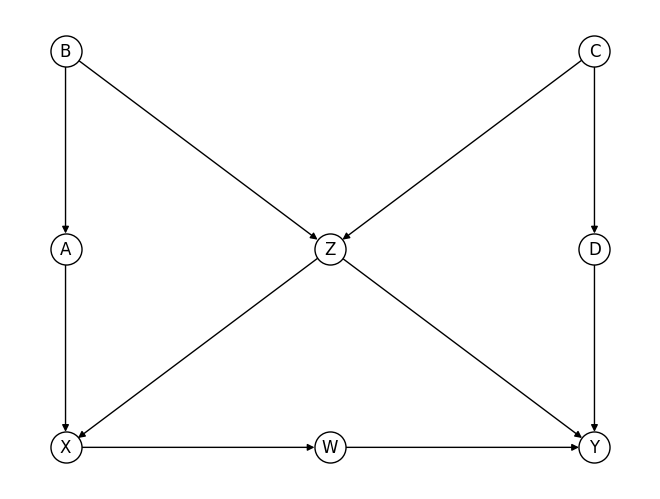

In [1]:
# we import networkx and create a directed graph
import networkx as nx
G = nx.DiGraph()

G.add_nodes_from(['A', 'B', 'C', 'D', 'W', 'X', 'Y', 'Z'])

G.add_edges_from([('B','A'), ('B','Z'), ('C','Z'), ('C','D'), 
                  ('A','X'), ('Z','X'), ('Z','Y'), ('D','Y'),
                 ('X','W'), ('W','Y')])

# we can visualise this graph (choosing node positions, colours, and sizes to make it more clear) 
# and save it to a .gml format (for using DoWhy later)
pos = {'B': (-1, 1),              'C': (1, 1),
         'A': (-1, 0), 'Z': (0, 0), 'D': (1, 0),
         'X': (-1, -1), 'W': (0, -1), 'Y': (1, -1),}
nx.draw(G, pos= pos, with_labels=True, node_size=500, node_color='w', edgecolors ='black')
nx.write_gml(G, "backdoor_criterion_graph.gml")

We can start by identifying the descendants of $X$, as these must <u>not</u> be in our adjustment set according to the backdoor criterion. The descendants of $X$ are: $X$, $W$, and $Y$.

In [2]:
# this function finds the descendants of node 'X' in graph G
# note that in this function they do not include 'X' as a descendant of 'X' - this is not the definition we use, so we add 'X'
nx.descendants(G,'X') | {'X'}

{'W', 'X', 'Y'}

We now consider every backdoor path from $X$ to $Y$, and find the variables for which we can/must adjust. We start off by importing the 'backdoor' class from DoWhy. Then, we create an undirected copy of our graph and call it H. This is so we can find all possible undirected paths between 'X' and 'Y'. Finally, we can use the 'is_backdoor' method from backdoor class to check which of these paths are backdoor paths.

In [3]:
# importing the backdoor class from DoWhy
from dowhy.causal_identifier import backdoor

# creating a copy of our graph G that is undirected
H = G.to_undirected()

C:\Users\jnevin\Anaconda3\envs\causal_data_science_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# the all_simple_paths function finds all possible undirected paths between 'X' and 'Y' in graph H
# the [x for x ...] is simply to get the values from the generator
all_possible_paths = [x for x in nx.all_simple_paths(H, 'X', 'Y')]

In [5]:
# we can create a Backdoor object with G, 'X', and 'Y'
# note that we are back to using the directed graph, G, as we only needed the undirected to find the paths
graph_nodes = backdoor.Backdoor(G, 'X', 'Y')

In [6]:
# we apply the is_backdoor function to each path to check if a path is a backdoor path
backdoor_paths_idx = [graph_nodes.is_backdoor(x) for x in all_possible_paths]

# finally, we filter out all non-backdoor paths from the list of all paths
backdoor_paths = [i for indx,i in enumerate(all_possible_paths) if backdoor_paths_idx[indx]]

In [7]:
# we can then view these paths
backdoor_paths

[['X', 'A', 'B', 'Z', 'C', 'D', 'Y'],
 ['X', 'A', 'B', 'Z', 'Y'],
 ['X', 'Z', 'C', 'D', 'Y'],
 ['X', 'Z', 'Y']]

Now we can find possible adjustment sets for each of these paths.

In [8]:
# we create a pandas dataframe to track the path and its colliders and non-colliders
import pandas as pd
import numpy as np
adjustment_variables = pd.DataFrame(columns=['path', 'colliders', 'non_colliders'])

The first path we consider is $X <- A <- B -> Z <- C -> D - > Y$.

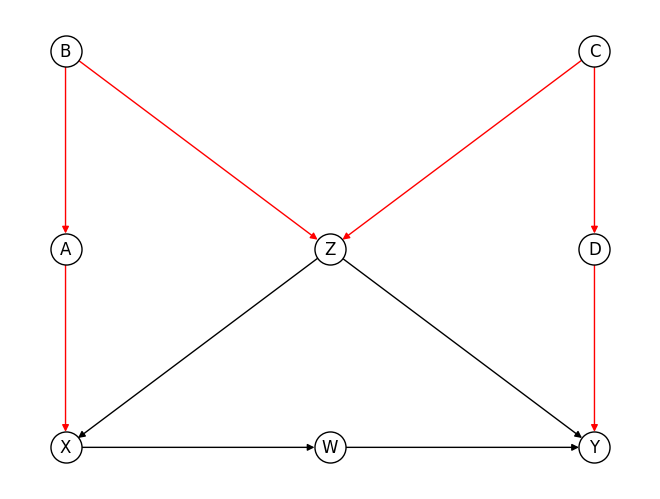

In [9]:
colors = ['r', 'r', 'r', 'r', 'r', 'r', 'black', 'black', 'black', 'black']
nx.draw(G, pos= pos, with_labels=True, node_size=500, node_color='w', edgecolors = 'black', edge_color =colors)

In [10]:
# this is the path we are testing
path = ['X', 'A', 'B', 'Z', 'C', 'D', 'Y']

In [11]:
# we create empty (for now) lists for our colliders and non-colliders
# we also create a variable for the length of the path
colliders = np.array([])
non_colliders = []
path_len = len(path)

In [12]:
# we loop through adjacent variables on the path, ignoring the source and target variables as potential colliders
for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
    # if there is an arrow pointing into node1 from both sides on the path, it is a collider
    if G.has_edge(node0, node1) and G.has_edge(node2, node1):
        colliders = np.append(colliders, list(nx.descendants(G,node1)) + [node1]) # so we add it (and all its descendants) to the list
# we flatten the list of list
colliders = colliders.flatten()

In [13]:
# any node on the path (excluding the source and target) that is not a collider is a non-collider
non_colliders = [x for x in path[1:-1] if x not in colliders]

In [14]:
# finally, we add the information to our dataframe, with the path, colliders, and non-colliders
adjustment_variables = adjustment_variables.append({'path':path, 'colliders': colliders, 
                                                    'non_colliders': non_colliders}, ignore_index=True)

C:\Users\jnevin\AppData\Local\Temp\ipykernel_26168\4239048847.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  adjustment_variables = adjustment_variables.append({'path':path, 'colliders': colliders,


In [15]:
adjustment_variables

,path,colliders,non_colliders
0,"[X, A, B, Z, C, D, Y]","[W, X, Y, Z]","[A, B, C, D]"


We now can see that we need either:

1. Not to condition on $Z$ or its descendants ($Y$, $W$, $X$) or
2. Condition on at least one of $A$, $B$, $C$, $D$

The second path we consider is $X <- A <- B -> Z - > Y$.

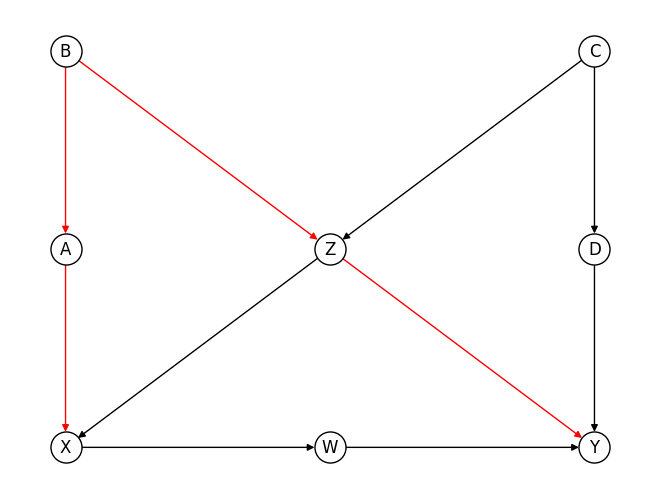

In [16]:
colors = ['r', 'r', 'r', 'black', 'black', 'black', 'black', 'black', 'black', 'r']
nx.draw(G, pos= pos, with_labels=True, node_size=500, node_color='w', edgecolors = 'black', edge_color =colors)

In [17]:
# this is the path we are testing
path = ['X', 'A', 'B', 'Z', 'Y']

# we create empty (for now) lists for our colliders and non-colliders
# we also create a variable for the length of the path
colliders = np.array([])
non_colliders = []
path_len = len(path)

# we loop through adjacent variables on the path, ignoring the source and target variables as potential colliders
for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
    # if there is an arrow pointing into node1 from both sides on the path, it is a collider
    if G.has_edge(node0, node1) and G.has_edge(node2, node1):
        colliders = np.append(colliders, list(nx.descendants(G,node1)) + [node1]) # so we add it (and all its descendants) to the list
# we flatten the list of list
colliders = colliders.flatten()
        
# any node on the path (excluding the source and target) that is not a collider is a non-collider
non_colliders = [x for x in path[1:-1] if x not in colliders]

# finally, we add the information to our dataframe, with the path, colliders, and non-colliders
adjustment_variables = adjustment_variables.append({'path':path, 'colliders': colliders, 
                                                    'non_colliders': non_colliders}, ignore_index=True)

adjustment_variables

C:\Users\jnevin\AppData\Local\Temp\ipykernel_26168\2584638431.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  non_colliders = [x for x in path[1:-1] if x not in colliders]
C:\Users\jnevin\AppData\Local\Temp\ipykernel_26168\2584638431.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  adjustment_variables = adjustment_variables.append({'path':path, 'colliders': colliders,


,path,colliders,non_colliders
0,"[X, A, B, Z, C, D, Y]","[W, X, Y, Z]","[A, B, C, D]"
1,"[X, A, B, Z, Y]",[],"[A, B, Z]"


 There are no colliders on this path, so we simply need to condition on at least one of $A$, $B$, or $Z$ (you may get some warnings due to there being no colliders).

The third path is $X <- Z - > Y$.

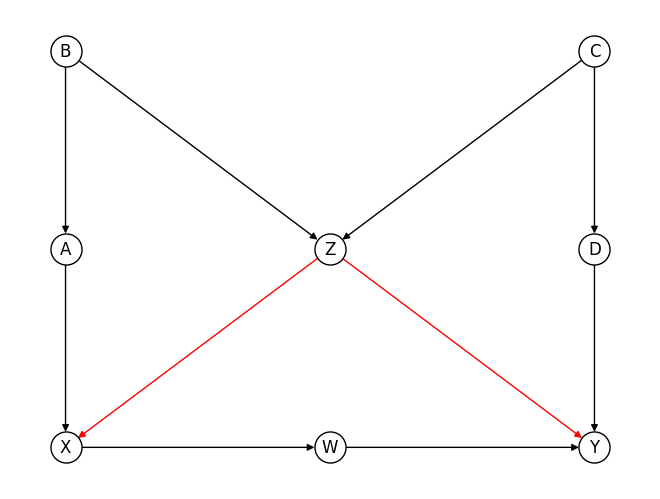

In [18]:
colors = ['black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'r', 'r']
nx.draw(G, pos= pos, with_labels=True, node_size=500, node_color='w', edgecolors = 'black', edge_color =colors)

In [19]:
# this is the path we are testing
path = ['X', 'Z', 'Y']

# we create empty (for now) lists for our colliders and non-colliders
# we also create a variable for the length of the path
colliders = np.array([])
non_colliders = []
path_len = len(path)

# we loop through adjacent variables on the path, ignoring the source and target variables as potential colliders
for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
    # if there is an arrow pointing into node1 from both sides on the path, it is a collider
    if G.has_edge(node0, node1) and G.has_edge(node2, node1):
        colliders = np.append(colliders, list(nx.descendants(G,node1)) + [node1]) # so we add it (and all its descendants) to the list
# we flatten the list of list
colliders = colliders.flatten()
        
# any node on the path (excluding the source and target) that is not a collider is a non-collider
non_colliders = [x for x in path[1:-1] if x not in colliders]

# finally, we add the information to our dataframe, with the path, colliders, and non-colliders
adjustment_variables = adjustment_variables.append({'path':path, 'colliders': colliders, 
                                                    'non_colliders': non_colliders}, ignore_index=True)

adjustment_variables

C:\Users\jnevin\AppData\Local\Temp\ipykernel_26168\4219723424.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  non_colliders = [x for x in path[1:-1] if x not in colliders]
C:\Users\jnevin\AppData\Local\Temp\ipykernel_26168\4219723424.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  adjustment_variables = adjustment_variables.append({'path':path, 'colliders': colliders,


,path,colliders,non_colliders
0,"[X, A, B, Z, C, D, Y]","[W, X, Y, Z]","[A, B, C, D]"
1,"[X, A, B, Z, Y]",[],"[A, B, Z]"
2,"[X, Z, Y]",[],[Z]


 There are no colliders on this path, so we need to condition on the one remaining variable, $Z$.

The final path is $X <- Z <- C -> D -> Y$. 

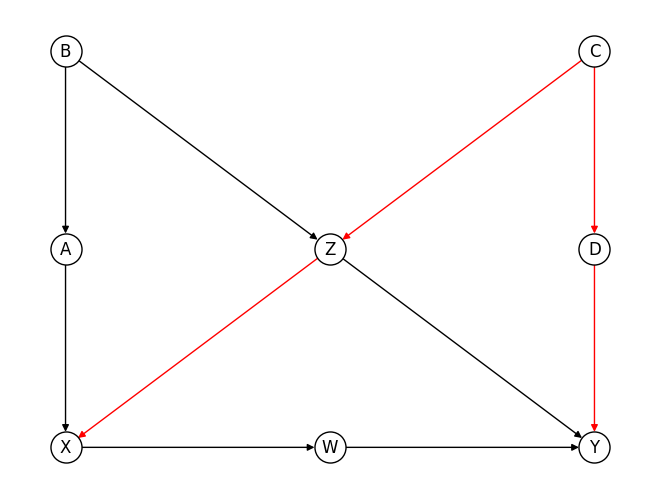

In [20]:
colors = ['black', 'black', 'black', 'r', 'r', 'r', 'black', 'black', 'r', 'black']
nx.draw(G, pos= pos, with_labels=True, node_size=500, node_color='w', edgecolors = 'black', edge_color =colors)

In [21]:
# this is the path we are testing
path = ['X', 'Z', 'C', 'D', 'Y']

# we create empty (for now) lists for our colliders and non-colliders
# we also create a variable for the length of the path
colliders = np.array([])
non_colliders = []
path_len = len(path)

# we loop through adjacent variables on the path, ignoring the source and target variables as potential colliders
for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
    # if there is an arrow pointing into node1 from both sides on the path, it is a collider
    if G.has_edge(node0, node1) and G.has_edge(node2, node1):
        colliders = np.append(colliders, list(nx.descendants(G,node1)) + [node1]) # so we add it (and all its descendants) to the list
# we flatten the list of list
colliders = colliders.flatten()
        
# any node on the path (excluding the source and target) that is not a collider is a non-collider
non_colliders = [x for x in path[1:-1] if x not in colliders]

# finally, we add the information to our dataframe, with the path, colliders, and non-colliders
adjustment_variables = adjustment_variables.append({'path':path, 'colliders': colliders, 
                                                    'non_colliders': non_colliders}, ignore_index=True)

adjustment_variables

C:\Users\jnevin\AppData\Local\Temp\ipykernel_26168\741921367.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  non_colliders = [x for x in path[1:-1] if x not in colliders]
C:\Users\jnevin\AppData\Local\Temp\ipykernel_26168\741921367.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  adjustment_variables = adjustment_variables.append({'path':path, 'colliders': colliders,


,path,colliders,non_colliders
0,"[X, A, B, Z, C, D, Y]","[W, X, Y, Z]","[A, B, C, D]"
1,"[X, A, B, Z, Y]",[],"[A, B, Z]"
2,"[X, Z, Y]",[],[Z]
3,"[X, Z, C, D, Y]",[],"[Z, C, D]"


Once again, there are no colliders on this path, so we can condition on at least one of $C$, $D$, or $Z$. 

Combining all conditions together, we have the following:

1. Not condition on $Z$ and its decendants ($Y$) OR condition on at least one of $A$, $B$, $C$, $D$
2. Condition on at least one of $A$, $B$, or $Z$
3. Condition on $Z$
4. Condition on at least one of $C$, $D$, or $Z$

So we need to condition on $Z$. This then satisfies conditions 2, 3, and 4. To satisfy 1, we now need to condition on at least one of $A$, $B$, $C$, or $D$. Thus, our possible sets are: {$Z$, $A$}, {$Z$, $B$}, ..., {$Z$, $A$, $B$, $C$, $D$}.

In [22]:
adjustment_variables

,path,colliders,non_colliders
0,"[X, A, B, Z, C, D, Y]","[W, X, Y, Z]","[A, B, C, D]"
1,"[X, A, B, Z, Y]",[],"[A, B, Z]"
2,"[X, Z, Y]",[],[Z]
3,"[X, Z, C, D, Y]",[],"[Z, C, D]"


DoWhy can find sets satisfying the backdoor criterion automatically. We simply provide it with the graph (in .gml format). We also need to provide it with data, but since we are only worried about the backdoor criterion for now, we can give it meaningless data (remember: the estimands are graph-specific, and don't rely on the data).

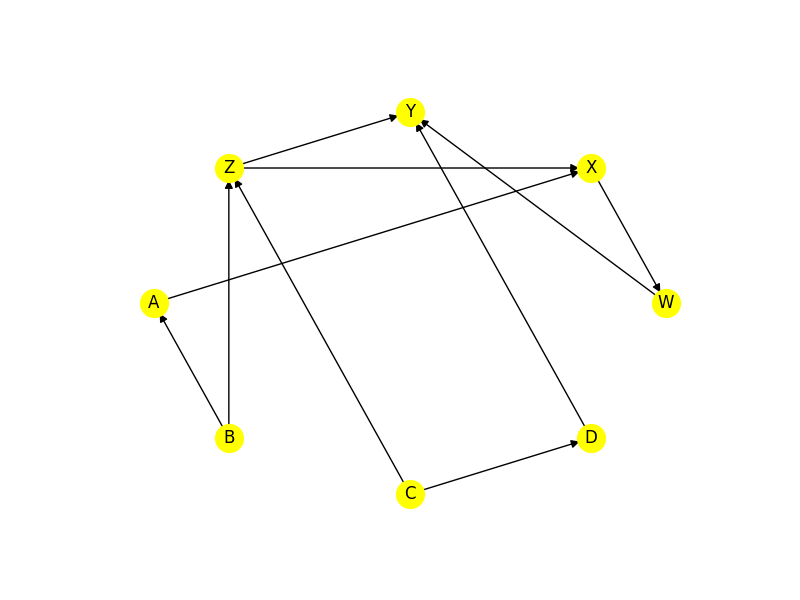

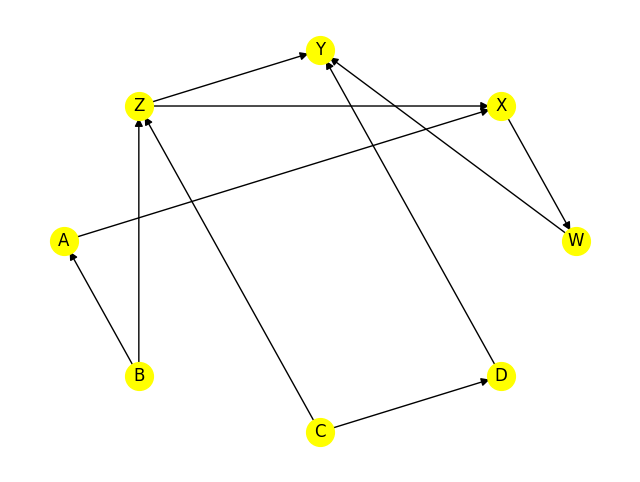

In [23]:
import dowhy
from dowhy import CausalModel

# creating arbitrary data
df = pd.DataFrame({'A':[1],'B':[1],'C':[1],'D':[1],'W':[1],'X':[1],
                  'Y': [1], 'Z': [1]})

# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

from IPython.display import Image, display

gml_graph = gml_to_string('backdoor_criterion_graph.gml')
# With GML string
model=CausalModel(
        data = df,
        treatment='X',
        outcome='Y',
        graph=gml_graph
        )
model.view_model()

display(Image(filename="causal_model.png", width = 200, height = 100))

In [24]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d            
────(E[Y|C,Z])
d[X]          
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,C,Z,U) = P(Y|X,C,Z)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([W])⎥
 ⎣d[W]    d[X]     ⎦
Estimand assumption 1, Full-mediation: W intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{W} then P(W|X,U) = P(W|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{W} and U→Y then P(Y|W, X, U) = P(Y|W, X)



Under Estimand 1, we can see the adjustment set identified by DoWhy. This set will be one of those we manually found, but can differ from run to run.

DoWhy's code for finding the backdoor criterion sets is available at: https://github.com/py-why/dowhy/blob/main/dowhy/causal_identifier/backdoor.py. You can look into this a bit if you want to understand better how DoWhy finds the adjustment sets. For example, you can access all the minimum-sized and maximum-sized adjustment sets as follows:

In [26]:
identifier = model.identifier
identifier.identify_backdoor(model._graph, model._treatment, model._outcome)

[{'backdoor_set': ('B', 'C', 'Z', 'D', 'A')},
 {'backdoor_set': ('B', 'Z')},
 {'backdoor_set': ('C', 'Z')},
 {'backdoor_set': ('Z', 'D')},
 {'backdoor_set': ('Z', 'A')}]